In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None) # Mostrar todas las columnas
import warnings

# Configuraciones para visualización (opcional)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Clustering para entendimiento de la base de datos
Usaremos k-means y DBSCAN para obtener insigths nuevos de la base de datos, obtener nuevas conclusiones y ver que podemos ajustar para un eventual modelo predictivo.

El objetivo es agrupar CVs que comparten caracteríticas similares y posteriormente compararlos con la variable Passed.
Así mismo nos puede permitir detectar anomalías o casos atípicos y eliminarlos del análisis

In [45]:
#Cargar datos
file_path = "../Bases/base_cvs/baseCVsIngVar.csv"

try:
    # El archivo parece tener un índice sin nombre al principio, lo usamos como índice del DF
    df_original = pd.read_csv(file_path, index_col=0)
    print("Datos cargados exitosamente.")
    print(f"Forma del DataFrame: {df_original.shape}")
except FileNotFoundError:
    print(f"Error: Archivo no encontrado en la ruta: {file_path}")
    # Detener la ejecución si no se encuentra el archivo
    raise

# Mostrar las primeras filas y la información general
print("\nInformación del DataFrame:")
df_original.info()
print("\nEstadísticas Descriptivas:")
print(df_original.describe())
print("\nPrimeras 5 filas:")
df_original.head()

Datos cargados exitosamente.
Forma del DataFrame: (622, 53)

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 622 entries, 0 to 621
Data columns (total 53 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Páginas                                           622 non-null    int64  
 1   professional_profile                              622 non-null    int64  
 2   education                                         622 non-null    int64  
 3   work_experience                                   622 non-null    int64  
 4   skills                                            622 non-null    int64  
 5   certifications                                    622 non-null    int64  
 6   achievements                                      622 non-null    int64  
 7   languages                                         622 non-null    int64  
 8   projects         

,Páginas,professional_profile,education,work_experience,skills,certifications,achievements,languages,projects,training_courses,volunteer_work,Orden Cronológico,Formato de Texto,Densidad de Información,Cantidad de Palabras,% Lenguaje de Técnico,LinkedIn,GitHub,Personal Website,Tablas,Errores de ortografia,Tamaño de fuente más usado,Legibilidad,Uso de negritas,Uso de cursivas,Uso de colores (excluyendo fondo blanco y links),Porcentaje de color real en la CV,Cantidad de imágenes o gráficos,Alineación principal,Consistencia de tamaños,Consistencia de márgenes,Passed,ratio_professional_profile,ratio_education,ratio_work_experience,ratio_skills,ratio_certifications,ratio_achievements,ratio_languages,ratio_projects,ratio_training_courses,ratio_volunteer_work,ratio_Errores de ortografia,tiene_perfil,tiene_educacion,tiene_certificaciones,tiene_proyectos,tiene_links_relevantes,tiene_skills,tiene_achievements,tiene_languages,tiene_projects,secciones_completas
0,2,39,28,72,98,69,0,0,13,48,0,1,2,18.20,493,3.655914,0,0,0,0,56,12.0,0,96,35,1,0.11,0,1,1,0,1,0.079108,0.056795,0.146045,0.198783,0.139959,0.000000,0.000000,0.026369,0.097363,0.000000,0.113590,1,1,1,1,0,1,0,0,1,7
1,6,306,369,80,0,57,9,4,182,389,0,1,0,20.20,1674,2.725118,0,0,0,0,123,12.0,0,52,64,0,0.00,1,1,0,1,1,0.182796,0.220430,0.047790,0.000000,0.034050,0.005376,0.002389,0.108722,0.232378,0.000000,0.073477,1,1,1,1,0,0,1,1,1,8
2,1,26,56,10,99,0,0,65,0,23,0,1,2,18.91,388,6.829268,0,0,0,1,82,9.0,1,0,0,1,32.12,9,1,0,0,1,0.067010,0.144330,0.025773,0.255155,0.000000,0.000000,0.167526,0.000000,0.059278,0.000000,0.211340,1,1,0,0,0,1,0,1,0,6
3,1,71,14,80,28,0,0,2,0,0,24,1,2,23.60,378,7.329843,1,0,0,0,34,10.1,0,53,0,1,0.98,0,1,1,0,1,0.187831,0.037037,0.211640,0.074074,0.000000,0.000000,0.005291,0.000000,0.000000,0.063492,0.089947,1,1,0,0,1,1,0,1,0,6
4,4,70,79,0,4,0,0,229,0,123,77,1,2,12.22,695,1.846154,0,0,0,1,94,10.0,0,111,0,1,3.51,3,1,1,1,1,0.100719,0.113669,0.000000,0.005755,0.000000,0.000000,0.329496,0.000000,0.176978,0.110791,0.135252,1,1,0,0,0,1,0,1,0,6


In [46]:
# 1. Selección de características:
#    Decide qué columnas usar para el clustering.
#    Generalmente, se usan variables numéricas o binarias.
#    Podríamos excluir las columnas de conteo originales si ya tenemos los ratios.
#    También podríamos excluir temporalmente variables muy específicas o categóricas complejas.

#    Ejemplo: Seleccionar todas las columnas de ratios, 'Passed', y algunas numéricas clave.
#    ¡AJUSTA ESTA LISTA SEGÚN TU CRITERIO!
features_to_cluster = [
    # Métricas generales
    'Páginas', 'Densidad de Información', 'Cantidad de Palabras', ' % Lenguaje de Técnico',
    'Errores de ortografia', 'Tamaño de fuente más usado', 'Legibilidad',
    'Uso de negritas', 'Uso de cursivas', 'Cantidad de imágenes o gráficos',
    'Porcentaje de color real en la CV',
    # Variables binarias/indicadoras
    'LinkedIn', 'GitHub', 'Personal Website', 'Tablas',
    'Alineación principal', 'Consistencia de tamaños', 'Consistencia de márgenes', 'Passed',
    # Ratios
    'ratio_professional_profile', 'ratio_education', 'ratio_work_experience',
    'ratio_skills', 'ratio_certifications', 'ratio_achievements', 'ratio_languages',
    'ratio_projects', 'ratio_training_courses', 'ratio_volunteer_work', 'ratio_Errores de ortografia',
    # Flags booleanos
    'tiene_perfil', 'tiene_educacion', 'tiene_certificaciones', 'tiene_proyectos',
    'tiene_links_relevantes', 'tiene_skills', 'tiene_achievements', 'tiene_languages',
     # 'tiene_projects' se repite, la omitimos
    'secciones_completas'
]

# Verificar si todas las columnas seleccionadas existen
missing_cols = [col for col in features_to_cluster if col not in df_original.columns]
if missing_cols:
    print(f"\nAdvertencia: Las siguientes columnas no se encontraron y serán omitidas: {missing_cols}")
    features_to_cluster = [col for col in features_to_cluster if col in df_original.columns]

df_cluster = df_original[features_to_cluster].copy()

# 2. Manejo de Nulos (si los hubiera)
#    Revisar si hay valores nulos en las columnas seleccionadas
print("\nValores nulos por columna seleccionada:")
print(df_cluster.isnull().sum())
#    Si hay nulos, decide cómo tratarlos (ej: imputar con media/mediana, eliminar filas)
#    df_cluster = df_cluster.fillna(df_cluster.median()) # Ejemplo de imputación con mediana

# 3. Escalado de Características
#    Es crucial para algoritmos basados en distancia como K-means y DBSCAN
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_cluster)

print(f"\nForma de los datos escalados: {scaled_features.shape}")


Valores nulos por columna seleccionada:
Páginas                              0
Densidad de Información              0
Cantidad de Palabras                 0
 % Lenguaje de Técnico               0
Errores de ortografia                0
Tamaño de fuente más usado           0
Legibilidad                          0
Uso de negritas                      0
Uso de cursivas                      0
Cantidad de imágenes o gráficos      0
Porcentaje de color real en la CV    0
LinkedIn                             0
GitHub                               0
Personal Website                     0
Tablas                               0
Alineación principal                 0
Consistencia de tamaños              0
Consistencia de márgenes             0
Passed                               0
ratio_professional_profile           0
ratio_education                      0
ratio_work_experience                0
ratio_skills                         0
ratio_certifications                 0
ratio_achievements     

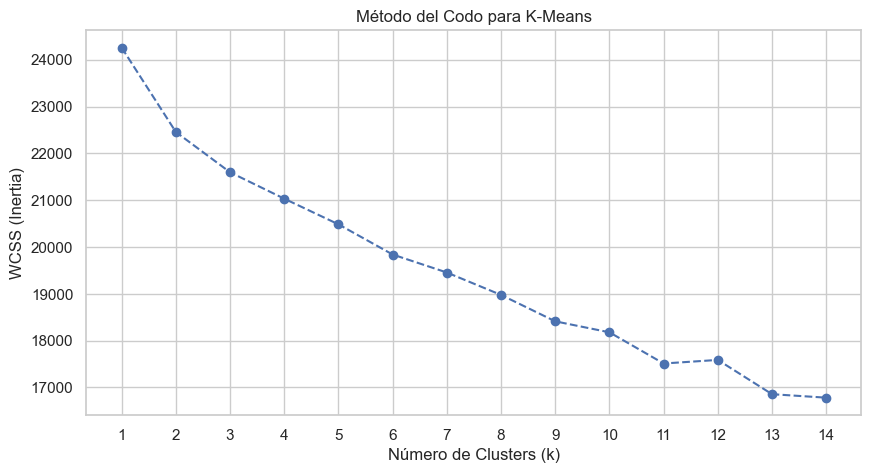

Para k=2, el silhouette score promedio es: 0.0756
Para k=3, el silhouette score promedio es: 0.0707
Para k=4, el silhouette score promedio es: 0.0582
Para k=5, el silhouette score promedio es: 0.0339
Para k=6, el silhouette score promedio es: 0.0499
Para k=7, el silhouette score promedio es: 0.0347
Para k=8, el silhouette score promedio es: 0.0444
Para k=9, el silhouette score promedio es: 0.0579
Para k=10, el silhouette score promedio es: 0.0574
Para k=11, el silhouette score promedio es: 0.0535
Para k=12, el silhouette score promedio es: 0.0459
Para k=13, el silhouette score promedio es: 0.0639
Para k=14, el silhouette score promedio es: 0.0531


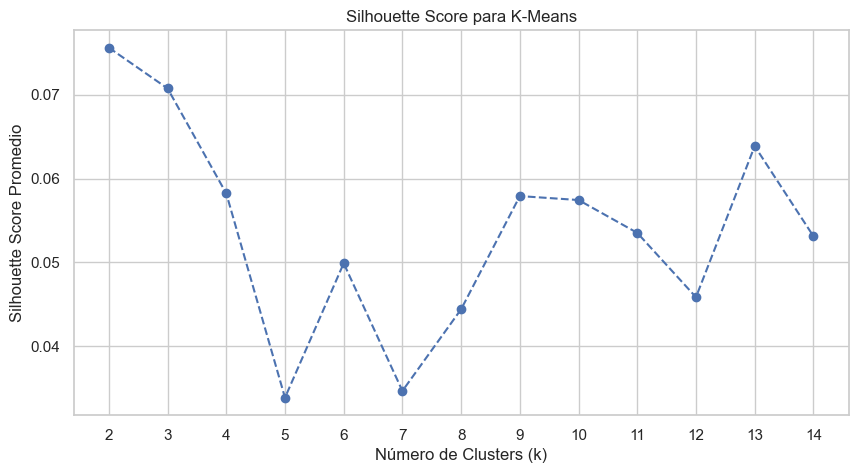


Aplicando K-Means con k=3...

Distribución de CVs por cluster K-Means:
kmeans_cluster
0    137
1    307
2    178
Name: count, dtype: int64


In [47]:
# 1. Encontrar el número óptimo de clusters (k)

# Método del Codo (Elbow Method)
wcss = [] # Within-Cluster Sum of Squares
k_range = range(1, 15) # Rango de k a probar

for k in k_range:
    kmeans_elbow = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans_elbow.fit(scaled_features)
    wcss.append(kmeans_elbow.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Método del Codo para K-Means')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Método de la Silueta (Silhouette Score)
silhouette_scores = []
k_range_silhouette = range(2, 15) # Silhouette requiere al menos 2 clusters

for k in k_range_silhouette:
    kmeans_silhouette = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    cluster_labels = kmeans_silhouette.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Para k={k}, el silhouette score promedio es: {silhouette_avg:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(k_range_silhouette, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score para K-Means')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score Promedio')
plt.xticks(k_range_silhouette)
plt.grid(True)
plt.show()

# 2. Aplicar K-Means con el 'k' elegido
#    Elige un 'k' basado en el codo y/o el pico de silhouette score.
#    Por ejemplo, si el codo está en k=5 o k=6
chosen_k = 3 # ¡¡¡ CAMBIA ESTE VALOR SEGÚN TU ANÁLISIS DE LOS GRÁFICOS !!!
print(f"\nAplicando K-Means con k={chosen_k}...")

kmeans = KMeans(n_clusters=chosen_k, init='k-means++', n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)

# Añadir las etiquetas de cluster al DataFrame original
df_original['kmeans_cluster'] = kmeans_labels
df_cluster['kmeans_cluster'] = kmeans_labels # También al df usado para escalar

print("\nDistribución de CVs por cluster K-Means:")
print(df_original['kmeans_cluster'].value_counts().sort_index())


In [48]:
# --- Célula 5: Análisis de Clusters K-Means ---

# Calcular características promedio por cluster
print(f"\nCaracterísticas promedio por cluster K-Means (k={chosen_k}):")
cluster_summary_kmeans = df_original.groupby('kmeans_cluster')[features_to_cluster].mean()

# Mostrar algunas características clave (ajusta según interés)
key_summary_cols = df_cluster.columns
# Filtrar por columnas que realmente existen
key_summary_cols = [col for col in key_summary_cols if col in cluster_summary_kmeans.columns]

print(cluster_summary_kmeans[key_summary_cols])

# Analizar la tasa de 'Passed' por cluster
print("\nTasa de 'Passed' promedio por cluster K-Means:")
print(df_original.groupby('kmeans_cluster')['Passed'].mean())


Características promedio por cluster K-Means (k=3):
                 Páginas  Densidad de Información  Cantidad de Palabras  \
kmeans_cluster                                                            
0               2.240876                18.091241            541.343066   
1               1.879479                18.288078            436.657980   
2               4.910112                16.742978           1044.966292   

                 % Lenguaje de Técnico  Errores de ortografia  \
kmeans_cluster                                                  
0                             5.353564              74.970803   
1                             5.205399              68.781759   
2                             4.390289             145.511236   

                Tamaño de fuente más usado  Legibilidad  Uso de negritas  \
kmeans_cluster                                                             
0                                 9.929197     0.401460        58.868613   
1                

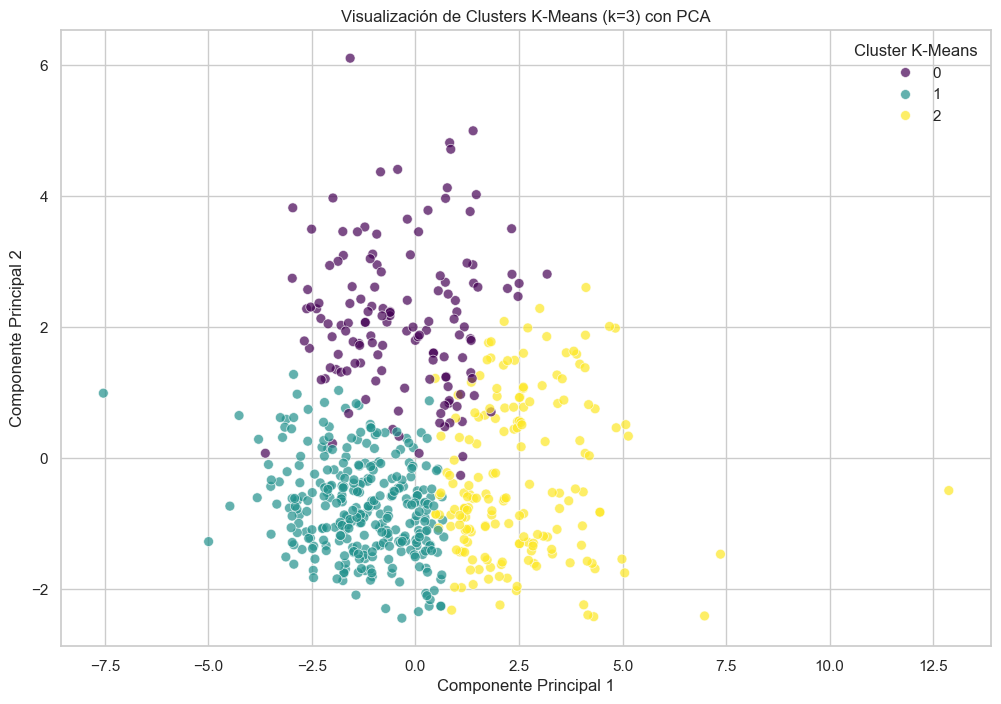


Varianza explicada por los 2 componentes PCA: 16.95%


In [49]:
# --- Célula 6: Visualización de Clusters K-Means (usando PCA) ---

# Reducir dimensionalidad a 2 componentes para visualizar
pca = PCA(n_components=2, random_state=42)
pca_features = pca.fit_transform(scaled_features)

# Crear un DataFrame con los componentes PCA y las etiquetas
df_pca = pd.DataFrame(data=pca_features, columns=['PCA1', 'PCA2'], index=df_original.index)
df_pca['kmeans_cluster'] = kmeans_labels

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='kmeans_cluster', palette='viridis', s=50, alpha=0.7)
plt.title(f'Visualización de Clusters K-Means (k={chosen_k}) con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster K-Means')
plt.grid(True)
plt.show()

print(f"\nVarianza explicada por los 2 componentes PCA: {pca.explained_variance_ratio_.sum():.2%}")


Se han reunido las CVs en 3 clusters principales:
- El cluster 0 tiene CVs más cortos en promedio, con ratios mayormente dedicados a explicar la experiencia laboral y menos los proyectos. Su % de *Passed* es del 40.8%
- El cluster 1 tiene CVs promedio, podemos decir de aquí que contamos con una longitud intermedia, así como ratios intermedios de las secciones. En general cuenta con los resultados intermedios entre el cluster 0 y el cluster 2, pudiendo decir que es el cluster "Promedio" de todas las CVs. El % de *Passed* es del 42,5%
- El cluster 2 es más largo en general que los otros CVs, tanto en páginas como en palabras. Le dedica más espacio a "Projects" que a skills y work experience. De la misma forma, tiene en promedio una mayor cantidad de secciones completas. Así mismo, tiene la tasa de *Passed* más alta, con 45.8%

---

## PCA
Realizaremos un análisis de componentes principales para entender los componentes mas importantes dentro de las variables, así mismo eliminar ruido, reducir las variables que nos ayude a comprender los datos de forma más compacta.

In [55]:
df_original = pd.read_csv(file_path, index_col=0)
print(f"Datos cargados correctamente desde '{file_path}'.")
print("Primeras 5 filas del DataFrame original:")
df_original.head()


Datos cargados correctamente desde '../Bases/base_cvs/baseCVsIngVar.csv'.
Primeras 5 filas del DataFrame original:


,Páginas,professional_profile,education,work_experience,skills,certifications,achievements,languages,projects,training_courses,volunteer_work,Orden Cronológico,Formato de Texto,Densidad de Información,Cantidad de Palabras,% Lenguaje de Técnico,LinkedIn,GitHub,Personal Website,Tablas,Errores de ortografia,Tamaño de fuente más usado,Legibilidad,Uso de negritas,Uso de cursivas,Uso de colores (excluyendo fondo blanco y links),Porcentaje de color real en la CV,Cantidad de imágenes o gráficos,Alineación principal,Consistencia de tamaños,Consistencia de márgenes,Passed,ratio_professional_profile,ratio_education,ratio_work_experience,ratio_skills,ratio_certifications,ratio_achievements,ratio_languages,ratio_projects,ratio_training_courses,ratio_volunteer_work,ratio_Errores de ortografia,tiene_perfil,tiene_educacion,tiene_certificaciones,tiene_proyectos,tiene_links_relevantes,tiene_skills,tiene_achievements,tiene_languages,tiene_projects,secciones_completas
0,2,39,28,72,98,69,0,0,13,48,0,1,2,18.20,493,3.655914,0,0,0,0,56,12.0,0,96,35,1,0.11,0,1,1,0,1,0.079108,0.056795,0.146045,0.198783,0.139959,0.000000,0.000000,0.026369,0.097363,0.000000,0.113590,1,1,1,1,0,1,0,0,1,7
1,6,306,369,80,0,57,9,4,182,389,0,1,0,20.20,1674,2.725118,0,0,0,0,123,12.0,0,52,64,0,0.00,1,1,0,1,1,0.182796,0.220430,0.047790,0.000000,0.034050,0.005376,0.002389,0.108722,0.232378,0.000000,0.073477,1,1,1,1,0,0,1,1,1,8
2,1,26,56,10,99,0,0,65,0,23,0,1,2,18.91,388,6.829268,0,0,0,1,82,9.0,1,0,0,1,32.12,9,1,0,0,1,0.067010,0.144330,0.025773,0.255155,0.000000,0.000000,0.167526,0.000000,0.059278,0.000000,0.211340,1,1,0,0,0,1,0,1,0,6
3,1,71,14,80,28,0,0,2,0,0,24,1,2,23.60,378,7.329843,1,0,0,0,34,10.1,0,53,0,1,0.98,0,1,1,0,1,0.187831,0.037037,0.211640,0.074074,0.000000,0.000000,0.005291,0.000000,0.000000,0.063492,0.089947,1,1,0,0,1,1,0,1,0,6
4,4,70,79,0,4,0,0,229,0,123,77,1,2,12.22,695,1.846154,0,0,0,1,94,10.0,0,111,0,1,3.51,3,1,1,1,1,0.100719,0.113669,0.000000,0.005755,0.000000,0.000000,0.329496,0.000000,0.176978,0.110791,0.135252,1,1,0,0,0,1,0,1,0,6


In [56]:
print("\nInformación del DataFrame:")
df_original.info()


Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 622 entries, 0 to 621
Data columns (total 53 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Páginas                                           622 non-null    int64  
 1   professional_profile                              622 non-null    int64  
 2   education                                         622 non-null    int64  
 3   work_experience                                   622 non-null    int64  
 4   skills                                            622 non-null    int64  
 5   certifications                                    622 non-null    int64  
 6   achievements                                      622 non-null    int64  
 7   languages                                         622 non-null    int64  
 8   projects                                          622 non-null    int64  
 9 

In [60]:
# --- Celda 3: Selección de Variables Numéricas para PCA ---
# PCA funciona SOLAMENTE con variables numéricas.
# Debemos seleccionar las columnas que son cuantitativas y relevantes para el análisis.
# Basado en los nombres, excluimos identificadores, flags binarios (a menos que queramos tratarlos numéricamente),
# y la variable 'Passed' si es nuestro objetivo a predecir o explicar.

# Lista de columnas potencialmente numéricas adecuadas para PCA (ajusta según tu criterio):
numeric_cols_candidates = df_original.columns.tolist()

# Verificar que las columnas existan en el DataFrame
numeric_cols = [col for col in numeric_cols_candidates if col in df_original.columns]

# Crear un nuevo DataFrame solo con las columnas seleccionadas
df_numeric = df_original[numeric_cols].copy()

# Convertir columnas a numérico si es necesario (manejar errores)
for col in df_numeric.columns:
    df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')

print(f"\nSe seleccionaron {len(df_numeric.columns)} columnas numéricas para PCA:")



Se seleccionaron 53 columnas numéricas para PCA:


In [62]:
# --- Celda 5: Estandarización de los Datos ---
# Es crucial escalar los datos antes de aplicar PCA, especialmente si las variables
# tienen diferentes unidades o rangos. Usaremos StandardScaler (media=0, desviación estándar=1).

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)

# Convertir de nuevo a DataFrame para mayor claridad (opcional)
df_scaled = pd.DataFrame(scaled_data, columns=df_numeric.columns, index=df_numeric.index)

print("\nPrimeras 5 filas de datos estandarizados:")
df_scaled.head()


Primeras 5 filas de datos estandarizados:


,Páginas,professional_profile,education,work_experience,skills,certifications,achievements,languages,projects,training_courses,volunteer_work,Orden Cronológico,Formato de Texto,Densidad de Información,Cantidad de Palabras,% Lenguaje de Técnico,LinkedIn,GitHub,Personal Website,Tablas,Errores de ortografia,Tamaño de fuente más usado,Legibilidad,Uso de negritas,Uso de cursivas,Uso de colores (excluyendo fondo blanco y links),Porcentaje de color real en la CV,Cantidad de imágenes o gráficos,Alineación principal,Consistencia de tamaños,Consistencia de márgenes,Passed,ratio_professional_profile,ratio_education,ratio_work_experience,ratio_skills,ratio_certifications,ratio_achievements,ratio_languages,ratio_projects,ratio_training_courses,ratio_volunteer_work,ratio_Errores de ortografia,tiene_perfil,tiene_educacion,tiene_certificaciones,tiene_proyectos,tiene_links_relevantes,tiene_skills,tiene_achievements,tiene_languages,tiene_projects,secciones_completas
0,-0.348402,-0.243218,-0.653131,0.280541,1.309171,1.026021,-0.361944,-0.570843,-0.563923,-0.039371,-0.373890,0.195952,0.429867,0.061430,-0.322702,-0.476112,-0.498995,-0.269098,-0.395138,-0.439866,-0.428789,1.481275,-0.711374,0.423665,0.465804,0.463512,-0.411355,-0.312079,0.040129,0.531483,-0.847486,1.160676,-0.116429,-0.778080,0.468859,1.794036,2.089683,-0.387479,-0.617569,-0.604624,0.288245,-0.371066,-0.365081,0.397853,0.177508,1.160676,0.610793,-0.673254,0.673254,-0.643146,-1.385708,0.610793,0.237330
1,1.338026,2.923054,2.871369,0.419443,-0.664510,0.785982,-0.047615,-0.480959,1.156239,4.678573,-0.373890,0.195952,-2.355313,0.370554,2.384100,-0.804658,-0.498995,-0.269098,-0.395138,-0.439866,0.366961,1.481275,-0.711374,-0.246326,1.121815,-2.157440,-0.422721,-0.225807,0.040129,-1.881528,1.179961,1.160676,1.012542,0.706646,-0.553533,-0.733956,0.150399,-0.262612,-0.584106,0.119674,1.931168,-0.371066,-0.512319,0.397853,0.177508,1.160676,0.610793,-0.673254,-1.485323,1.554858,0.721653,0.610793,0.890511
2,-0.770009,-0.397381,-0.363730,-0.795954,1.329311,-0.354206,-0.361944,0.889773,-0.696244,-0.385262,-0.373890,0.195952,0.429867,0.171169,-0.563357,0.644001,-0.498995,-0.269098,-0.395138,-0.071137,-0.119991,-0.841269,1.405730,-1.038133,-0.325932,0.463512,2.896092,0.464374,0.040129,-1.881528,-0.847486,1.160676,-0.248145,0.016158,-0.782627,2.510935,-0.473087,-0.387479,1.728503,-0.836544,-0.175188,-0.371066,-0.006285,0.397853,0.177508,-0.861567,-1.637215,-0.673254,0.673254,-0.643146,0.721653,-1.637215,-0.415852
3,-0.770009,0.136261,-0.797832,0.419443,-0.100601,-0.354206,-0.361944,-0.525901,-0.696244,-0.703481,0.637788,0.195952,0.429867,0.896065,-0.586277,0.820691,2.004028,-0.269098,-0.395138,-0.439866,-0.690080,0.010331,-0.711374,-0.231099,-0.325932,0.463512,-0.321462,-0.312079,0.040129,0.531483,-0.847486,1.160676,1.067363,-0.957353,1.151415,0.208070,-0.473087,-0.387479,-0.543472,-0.836544,-0.896516,0.991593,-0.451864,0.397853,0.177508,-0.861567,-1.637215,1.485323,0.673254,-0.643146,0.721653,-1.637215,-0.415852
4,0.494812,0.124402,-0.126007,-0.969582,-0.583951,-0.354206,-0.361944,4.575019,-0.696244,0.998300,2.871911,0.195952,0.429867,-0.862852,0.140274,-1.114910,-0.498995,-0.269098,-0.395138,-0.071137,0.022532,-0.067087,-0.711374,0.652071,-0.325932,0.463512,-0.060048,-0.053262,0.040129,0.531483,1.179961,1.160676,0.118885,-0.262040,-1.050810,-0.660763,-0.473087,-0.387479,3.996779,-0.836544,1.257044,2.006726,-0.285571,0.397853,0.177508,-0.861567,-1.637215,-0.673254,0.673254,-0.643146,0.721653,-1.637215,-0.415852


In [63]:
# --- Celda 6: Aplicación de PCA ---
# Inicialmente, aplicamos PCA sin especificar el número de componentes
# para ver cuánta varianza explica cada uno.

pca = PCA() # Sin n_components especificado inicialmente
pca.fit(df_scaled)

PCA()

In [64]:
# --- Celda 7: Análisis de la Varianza Explicada ---
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

print("\nVarianza explicada por cada componente principal:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"  PC{i+1}: {ratio:.4f} ({ratio*100:.2f}%)")

print("\nVarianza explicada acumulada:")
for i, cum_ratio in enumerate(cumulative_variance_ratio):
    print(f"  Hasta PC{i+1}: {cum_ratio:.4f} ({cum_ratio*100:.2f}%)")


Varianza explicada por cada componente principal:
  PC1: 0.1135 (11.35%)
  PC2: 0.0554 (5.54%)
  PC3: 0.0486 (4.86%)
  PC4: 0.0469 (4.69%)
  PC5: 0.0463 (4.63%)
  PC6: 0.0421 (4.21%)
  PC7: 0.0417 (4.17%)
  PC8: 0.0389 (3.89%)
  PC9: 0.0378 (3.78%)
  PC10: 0.0363 (3.63%)
  PC11: 0.0343 (3.43%)
  PC12: 0.0317 (3.17%)
  PC13: 0.0299 (2.99%)
  PC14: 0.0286 (2.86%)
  PC15: 0.0233 (2.33%)
  PC16: 0.0232 (2.32%)
  PC17: 0.0210 (2.10%)
  PC18: 0.0207 (2.07%)
  PC19: 0.0187 (1.87%)
  PC20: 0.0186 (1.86%)
  PC21: 0.0178 (1.78%)
  PC22: 0.0166 (1.66%)
  PC23: 0.0163 (1.63%)
  PC24: 0.0152 (1.52%)
  PC25: 0.0144 (1.44%)
  PC26: 0.0135 (1.35%)
  PC27: 0.0131 (1.31%)
  PC28: 0.0129 (1.29%)
  PC29: 0.0120 (1.20%)
  PC30: 0.0117 (1.17%)
  PC31: 0.0108 (1.08%)
  PC32: 0.0107 (1.07%)
  PC33: 0.0101 (1.01%)
  PC34: 0.0096 (0.96%)
  PC35: 0.0082 (0.82%)
  PC36: 0.0068 (0.68%)
  PC37: 0.0055 (0.55%)
  PC38: 0.0051 (0.51%)
  PC39: 0.0046 (0.46%)
  PC40: 0.0038 (0.38%)
  PC41: 0.0031 (0.31%)
  PC42: 0.0028

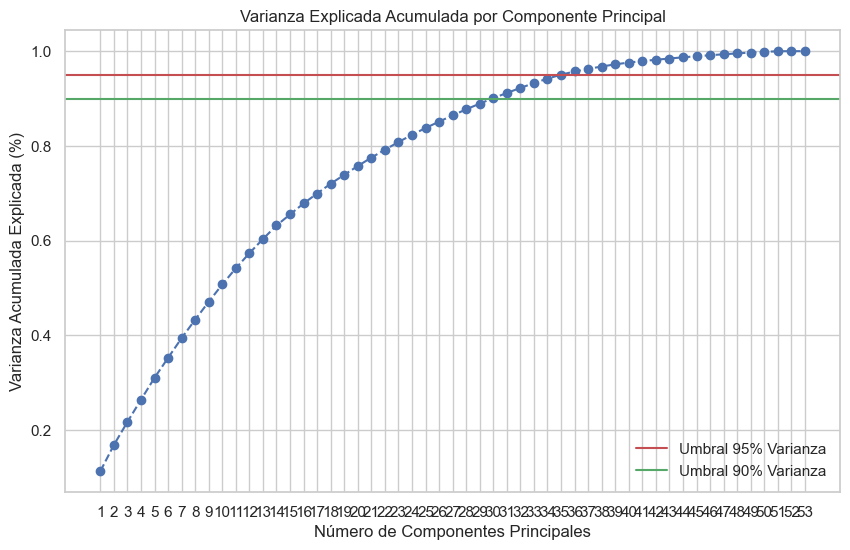

In [65]:
# --- Celda 8: Gráfico de Varianza Explicada Acumulada ---
# Este gráfico ayuda a decidir cuántos componentes retener (método del codo o umbral).

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.title('Varianza Explicada Acumulada por Componente Principal')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada Explicada (%)')
plt.grid(True)
# Añadir una línea para el umbral del 95% (o el que consideres)
plt.axhline(y=0.95, color='r', linestyle='-', label='Umbral 95% Varianza')
plt.axhline(y=0.90, color='g', linestyle='-', label='Umbral 90% Varianza')
plt.legend(loc='best')
plt.xticks(range(1, len(cumulative_variance_ratio) + 1)) # Asegura ticks enteros
plt.show()

In [70]:
# --- Celda 9: Decidir Número de Componentes y Re-aplicar PCA ---
# Basándote en el gráfico anterior y los porcentajes acumulados, decide cuántos
# componentes (n_components) quieres conservar.
# Por ejemplo, para capturar ~95% de la varianza.
# Busca el número de componentes donde la curva empieza a aplanarse ("codo")
# o el número que cruza tu umbral deseado (e.g., 0.90 o 0.95).

# Encuentra cuántos componentes se necesitan para explicar al menos el 95% de la varianza
n_components_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1
print(f"\nNúmero de componentes para explicar al menos el 95% de la varianza: {n_components_90}")

# Puedes elegir este número o uno diferente según tu análisis.
# Vamos a usar n_components_95 para el ejemplo:
n_components_final = n_components_90
# O elige un número fijo si prefieres, por ejemplo: n_components_final = 10

print(f"\nAplicando PCA final con {n_components_final} componentes...")
pca_final = PCA(n_components=n_components_final)
principal_components = pca_final.fit_transform(df_scaled)

# Crear un DataFrame con los componentes principales
pc_columns = [f'PC{i+1}' for i in range(n_components_final)]
df_pca = pd.DataFrame(data=principal_components, columns=pc_columns, index=df_scaled.index)

print(f"\nPrimeras 5 filas del DataFrame con {n_components_final} Componentes Principales:")
df_pca.head()



Número de componentes para explicar al menos el 95% de la varianza: 30

Aplicando PCA final con 30 componentes...

Primeras 5 filas del DataFrame con 30 Componentes Principales:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,0.016036,-1.319149,-0.493218,-2.094975,1.743631,-0.037187,-0.247702,-0.888726,-1.267553,-0.665279,0.751789,1.496467,0.973624,0.040654,-0.831137,0.497687,-1.222823,0.864356,1.034873,1.120778,0.259097,0.156644,0.027397,-0.432086,0.585830,0.040295,0.014907,-0.804970,-0.193309,-0.666450
1,6.099091,-0.340031,-2.305978,-0.788364,-2.282758,0.553291,-0.239042,0.668606,2.625217,1.834584,-0.481342,0.293453,2.955770,0.623120,1.015011,-1.015989,-0.288888,-0.145182,0.944054,0.145948,0.286666,-1.224387,-0.073627,1.328275,-0.645309,-0.143058,1.000157,-0.170321,0.989425,0.684678
2,-2.861189,-2.372771,-0.170084,2.048722,0.888284,-0.547335,-0.994957,-1.651902,-0.848113,-1.056001,0.177036,-0.767449,0.293551,0.927252,1.514385,0.063439,0.528747,-0.387088,0.591156,-0.488001,-0.287994,-0.735569,2.429044,0.018281,-0.248827,-0.971841,2.142106,0.384155,-0.510016,0.713880
3,-2.540119,-1.140543,-0.140512,1.145857,0.624359,0.404226,2.215802,-0.342111,0.689281,0.135383,1.496138,0.511482,-0.116712,-0.698671,0.418194,0.083006,-0.010608,-0.184456,0.093766,1.016954,-0.298513,0.232708,0.994495,0.470477,-0.851448,1.006759,-1.119124,-0.840174,0.640036,-0.398843
4,-0.135096,-1.189355,-0.501480,4.795703,-1.770888,-0.652354,-0.619835,-1.260035,2.385386,-3.518528,-2.442196,0.475328,1.383091,-1.162530,-0.364739,1.340099,1.383633,-0.523106,0.787238,0.304151,0.526875,-0.509153,0.581875,-1.019029,0.574097,0.427848,-0.169265,-0.364557,-1.213523,-1.306697


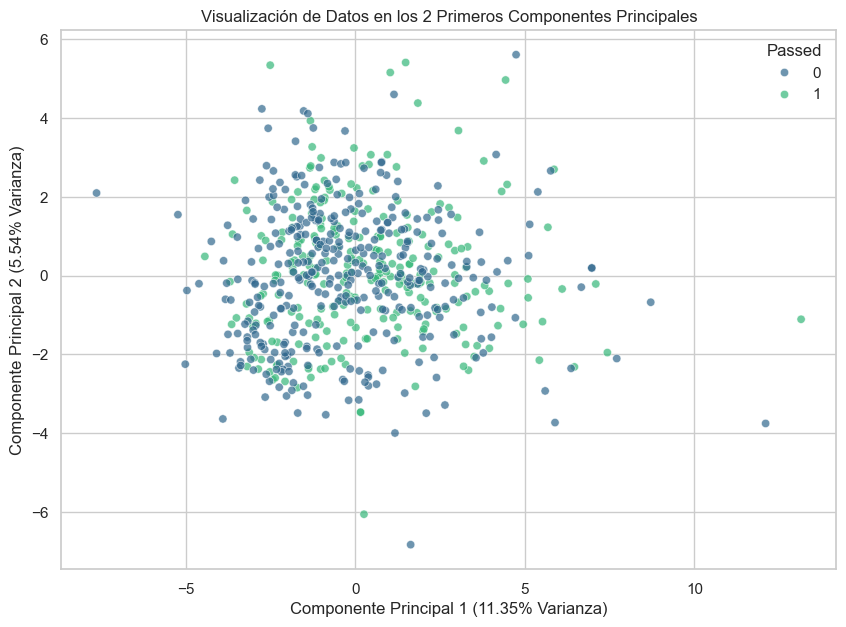

In [71]:
# --- Celda 10: (Opcional) Visualización de los 2 Primeros Componentes ---
# Si n_components_final >= 2, podemos visualizar los datos en el espacio de los
# dos primeros componentes principales.
# Podemos colorear los puntos según alguna variable original interesante, como 'Passed'.

if n_components_final >= 2 and 'Passed' in df_original.columns:
    plt.figure(figsize=(10, 7))

    # Asegúrate de que 'Passed' esté alineado con el índice de df_pca
    target_variable = df_original.loc[df_pca.index, 'Passed']

    sns.scatterplot(x='PC1', y='PC2', hue=target_variable, data=df_pca, palette='viridis', alpha=0.7)

    plt.title('Visualización de Datos en los 2 Primeros Componentes Principales')
    plt.xlabel('Componente Principal 1 ({:.2f}% Varianza)'.format(pca_final.explained_variance_ratio_[0]*100))
    plt.ylabel('Componente Principal 2 ({:.2f}% Varianza)'.format(pca_final.explained_variance_ratio_[1]*100))
    plt.grid(True)
    plt.legend(title='Passed')
    plt.show()
elif n_components_final >= 2:
     plt.figure(figsize=(10, 7))
     sns.scatterplot(x='PC1', y='PC2', data=df_pca, alpha=0.7)
     plt.title('Visualización de Datos en los 2 Primeros Componentes Principales')
     plt.xlabel('Componente Principal 1 ({:.2f}% Varianza)'.format(pca_final.explained_variance_ratio_[0]*100))
     plt.ylabel('Componente Principal 2 ({:.2f}% Varianza)'.format(pca_final.explained_variance_ratio_[1]*100))
     plt.grid(True)
     plt.show()

In [72]:
# --- Celda 11: (Opcional) Interpretación de Componentes (Loadings) ---
# Los "loadings" indican cuánto contribuye cada variable original (estandarizada)
# a cada componente principal. Valores altos (positivos o negativos) indican
# una fuerte influencia de esa variable en el componente.

if n_components_final > 0:
    loadings = pd.DataFrame(pca_final.components_.T, # Transponer para tener variables en filas
                            columns=pc_columns,     # Columnas son los PCs
                            index=df_numeric.columns) # Filas son las variables originales

    print(f"\nLoadings (contribución de variables originales a los {n_components_final} PCs):")
    print(loadings.head()) # Mostrar solo las primeras filas para brevedad

    # Puedes analizar los loadings para entender qué representa cada PC.
    # Por ejemplo, para PC1:
    print("\nVariables con mayor influencia (absoluta) en PC1:")
    print(loadings['PC1'].abs().sort_values(ascending=False).head(10))

    # Si tienes pocos componentes (ej. 2 o 3), puedes visualizar los loadings:
    if n_components_final <= 5: # Visualizar si son pocos componentes
         plt.figure(figsize=(12, 8))
         sns.heatmap(loadings, cmap='viridis', annot=True, fmt=".2f")
         plt.title('Heatmap de Loadings de PCA')
         plt.show()



Loadings (contribución de variables originales a los 30 PCs):
                           PC1       PC2       PC3       PC4       PC5  \
Páginas               0.295144 -0.051632 -0.108774 -0.030879 -0.056373   
professional_profile  0.198799 -0.082227 -0.110197  0.036800  0.008344   
education             0.212293 -0.151172 -0.125710  0.043121 -0.193802   
work_experience       0.075471 -0.108139 -0.189998  0.051905 -0.075264   
skills                0.073672 -0.265009 -0.121243  0.052880  0.380300   

                           PC6       PC7       PC8       PC9      PC10  \
Páginas              -0.029979  0.027770  0.017169  0.024142 -0.238530   
professional_profile  0.160464 -0.018391 -0.143609  0.346579  0.014131   
education            -0.096576 -0.050147 -0.057529  0.011072  0.313162   
work_experience      -0.065369  0.028315  0.392292 -0.180886 -0.023193   
skills               -0.007231  0.027605 -0.024466 -0.235364 -0.049814   

                          PC11      PC12      P